In [2]:
import os

from io import BytesIO

import requests
import pandas as pd
import numpy as np

import seaborn as sns

In [3]:
r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vRETovKvws1dtlZHoisnz7SlZp9MVRjRBLEMKL8a13WRE73FMe_PixNkLEsmgdQVrsO4Vq1lbGVSkfL/pub?gid=193004713&single=true&output=csv')
data = r.content

fe = pd.read_csv(BytesIO(data))

fe.to_csv("raw_dataset.csv")

In [4]:
catalysts = len(fe[["DOI", "Article name"]].drop_duplicates())
articles = len(fe[["DOI"]].drop_duplicates())
print(f"Unique articles: {articles}\nUnique catalysts: {catalysts}")

Unique articles: 53
Unique catalysts: 146


In [5]:
fe = fe.iloc[1:,:]

In [6]:
fe[fe.columns[fe.isna().any()]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4139 entries, 1 to 4139
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Autor                           688 non-null    object 
 1   Journal                         2448 non-null   object 
 2   IF                              913 non-null    object 
 3   Stability, hour                 1826 non-null   float64
 4   Key Product                     2466 non-null   object 
 5   Formula                         2572 non-null   object 
 6   Compound_2                      3120 non-null   object 
 7   Pore size, nm                   396 non-null    float64
 8   width min (nm)                  4083 non-null   float64
 9   width max (nm)                  4083 non-null   float64
 10  length min (nm)                 4048 non-null   float64
 11  length aver (nm)                4104 non-null   float64
 12  length max (nm)                 40

In [7]:
fe.columns

Index(['Number', 'Autor', 'Publication', 'Title', 'Journal', 'IF', 'DOI',
       'Stability, hour', 'Key Product', 'Article name', 'Formula',
       'Compound_1', 'Compound_2', 'Cat./Support ratio, % (at)',
       'Morphology (TEM/SEM)', 'Pore size, nm', 'width min (nm)',
       'width aver (nm)', 'width max (nm)', 'length min (nm)',
       'length aver (nm)', 'length max (nm)', 'Cu, % (at.)', 'Cu+, % (at.)',
       'Cu(2+), % (at.)', 'Base', 'electrolyte', 'conc, M', 'pH', 'RHE vs V',
       'Product', 'FE, %', 'Time, h', 'Type of reactor', 'Loading, μg/cm2',
       'Add_carbon, %', 'Surface area of electrode, cm2',
       'Flow rate CO2, ml/min', 'Volume, cm3'],
      dtype='object')

In [8]:
# Dropping columns with technical information about articles

col_to_drop = ["Number", "Publication", "Title", "Autor", "Journal", "IF", "Volume, cm3", "Formula"]
fe_cl = fe.drop([col for col in col_to_drop if col in fe.columns], axis=1).copy()

In [9]:
fe_cl["Add_carbon, %"] = fe_cl["Add_carbon, %"].fillna(0)
fe_cl["Time, h"] = fe_cl["Time, h"].fillna(1)
fe_cl["Pore size, nm"] = fe_cl["Pore size, nm"].fillna(0)
fe_cl["Add_carbon, %"] = fe_cl["Add_carbon, %"].fillna(0)

fe_cl["Compound_2"] = fe_cl["Compound_2"].fillna("No")

In [10]:
fe_cl[fe_cl.columns[fe_cl.isna().any()]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4139 entries, 1 to 4139
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Stability, hour                 1826 non-null   float64
 1   Key Product                     2466 non-null   object 
 2   width min (nm)                  4083 non-null   float64
 3   width max (nm)                  4083 non-null   float64
 4   length min (nm)                 4048 non-null   float64
 5   length aver (nm)                4104 non-null   float64
 6   length max (nm)                 4048 non-null   float64
 7   Loading, μg/cm2                 4022 non-null   float64
 8   Surface area of electrode, cm2  3982 non-null   float64
 9   Flow rate CO2, ml/min           3543 non-null   float64
dtypes: float64(9), object(1)
memory usage: 323.5+ KB


In [11]:
fe_cl.columns

Index(['DOI', 'Stability, hour', 'Key Product', 'Article name', 'Compound_1',
       'Compound_2', 'Cat./Support ratio, % (at)', 'Morphology (TEM/SEM)',
       'Pore size, nm', 'width min (nm)', 'width aver (nm)', 'width max (nm)',
       'length min (nm)', 'length aver (nm)', 'length max (nm)', 'Cu, % (at.)',
       'Cu+, % (at.)', 'Cu(2+), % (at.)', 'Base', 'electrolyte', 'conc, M',
       'pH', 'RHE vs V', 'Product', 'FE, %', 'Time, h', 'Type of reactor',
       'Loading, μg/cm2', 'Add_carbon, %', 'Surface area of electrode, cm2',
       'Flow rate CO2, ml/min'],
      dtype='object')

## Filling Surface area, flow rate

In [12]:
fe_exper = fe_cl[["DOI", "Type of reactor", "Loading, μg/cm2", "Surface area of electrode, cm2", "Flow rate CO2, ml/min"]].drop_duplicates().copy()
surf_nan = fe_exper["Surface area of electrode, cm2"].isna()

In [13]:
fe_exper_flow = fe_exper[fe_exper["Type of reactor"] == "Flow cell"]
fe_exper_h_cell = fe_exper[fe_exper["Type of reactor"] == "H-cell"]

In [14]:
surf_mode = fe_exper_flow["Surface area of electrode, cm2"].mode()[0]
print(f"Mode of Flow-cell electrode surface: {surf_mode}")

fe_cl["Surface area of electrode, cm2"] = fe_cl["Surface area of electrode, cm2"].fillna(surf_mode)

Mode of Flow-cell electrode surface: 1.0


In [15]:
flow_flow_mode = fe_exper_flow["Flow rate CO2, ml/min"].mode()[0]
print(f"Mode of Flow rate for Flow-cell: {flow_flow_mode}")

fe_cl.loc[fe_cl["Type of reactor"] == "Flow cell", "Flow rate CO2, ml/min"] = fe_cl.loc[fe_cl["Type of reactor"] == "Flow cell", "Flow rate CO2, ml/min"].fillna(flow_flow_mode)

Mode of Flow rate for Flow-cell: 20.0


In [16]:
h_cell_flow_mode = fe_exper_h_cell["Flow rate CO2, ml/min"].mode()[0]
print(f"Mode of Flow rate for H-cell: {h_cell_flow_mode}")


fe_cl.loc[fe_cl["Type of reactor"] == "H-cell", "Flow rate CO2, ml/min"] = fe_cl.loc[fe_cl["Type of reactor"] == "H-cell", "Flow rate CO2, ml/min"].fillna(h_cell_flow_mode)

Mode of Flow rate for H-cell: 20.0


In [17]:
loading_mode = fe_cl["Loading, μg/cm2"].mode()[0]
print(f"Mode of loading: {loading_mode}")

fe_cl["Loading, μg/cm2"] = fe_cl["Loading, μg/cm2"].fillna(loading_mode)

Mode of loading: 1000.0


In [18]:
def check_empty(df):
    return df[df.columns[df.isna().any()]].info()

## Deleting abudant time

In [19]:
fe_cl.columns

Index(['DOI', 'Stability, hour', 'Key Product', 'Article name', 'Compound_1',
       'Compound_2', 'Cat./Support ratio, % (at)', 'Morphology (TEM/SEM)',
       'Pore size, nm', 'width min (nm)', 'width aver (nm)', 'width max (nm)',
       'length min (nm)', 'length aver (nm)', 'length max (nm)', 'Cu, % (at.)',
       'Cu+, % (at.)', 'Cu(2+), % (at.)', 'Base', 'electrolyte', 'conc, M',
       'pH', 'RHE vs V', 'Product', 'FE, %', 'Time, h', 'Type of reactor',
       'Loading, μg/cm2', 'Add_carbon, %', 'Surface area of electrode, cm2',
       'Flow rate CO2, ml/min'],
      dtype='object')

In [20]:
fe_time = fe_cl[["DOI", "Article name", "Time, h"]].drop_duplicates()

In [21]:
fe_test = fe_cl.copy()
fe_test["Time, h"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4139 entries, 1 to 4139
Series name: Time, h
Non-Null Count  Dtype  
--------------  -----  
4139 non-null   float64
dtypes: float64(1)
memory usage: 32.5 KB


In [22]:
fe_test["Diff"] = abs(fe_test["Time, h"] - 1)
grouped = fe_test.groupby(["DOI", "Article name"])
min_diff = grouped["Diff"].transform("min")
result_df = fe_test[fe_test['Diff'] == min_diff]
fe_cl = result_df.copy()

In [23]:
to_drop = ["Diff", "Stability, hour", "Key Product"]
to_drop_1 = [drop for drop in to_drop if drop in list(fe_cl.columns)]
to_drop_1

['Diff', 'Stability, hour', 'Key Product']

In [24]:
fe_cl = result_df.drop(to_drop_1, axis=1).copy()

In [25]:
fe_cl = fe_cl.reset_index(drop=True)

In [26]:
fe_cl.columns

Index(['DOI', 'Article name', 'Compound_1', 'Compound_2',
       'Cat./Support ratio, % (at)', 'Morphology (TEM/SEM)', 'Pore size, nm',
       'width min (nm)', 'width aver (nm)', 'width max (nm)',
       'length min (nm)', 'length aver (nm)', 'length max (nm)', 'Cu, % (at.)',
       'Cu+, % (at.)', 'Cu(2+), % (at.)', 'Base', 'electrolyte', 'conc, M',
       'pH', 'RHE vs V', 'Product', 'FE, %', 'Time, h', 'Type of reactor',
       'Loading, μg/cm2', 'Add_carbon, %', 'Surface area of electrode, cm2',
       'Flow rate CO2, ml/min'],
      dtype='object')

# Checking variables format

In [27]:
if fe_cl["RHE vs V"].dtypes != float:
    fe_cl["RHE vs V"] = fe_cl["RHE vs V"].str.replace(',', '.')
    fe_cl["RHE vs V"] = fe_cl["RHE vs V"].str.replace(' ', '')
    fe_cl["RHE vs V"] = fe_cl["RHE vs V"].str.replace('–', '-')
    fe_cl["RHE vs V"] = fe_cl["RHE vs V"].astype(float)

fe_cl["Base"] = fe_cl["Base"].replace('gas diffusion layer', "gasdiffusion electrode")

In [28]:
for i in range(0, len(fe_cl)):
    val = fe_cl.loc[i, "Compound_1"]
    try:
        fe_cl.loc[i, "Compound_1"] = val.replace(" ", "")
    except AttributeError:
        print(val)

for i in range(0, len(fe_cl)):
    val = fe_cl.loc[i, "Compound_2"]
    fe_cl.loc[i, "Compound_2"] = val.replace(" ", "")

# Visualization

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
not_to_display = ["DOI", "Article name"]
obj_col_for_an = list(fe_cl.select_dtypes(include="object").columns)
obj_col_for_an = [col for col in obj_col_for_an if col not in not_to_display]
obj_col_for_an

['Compound_1',
 'Compound_2',
 'Morphology (TEM/SEM)',
 'Base',
 'electrolyte',
 'Product',
 'Type of reactor']

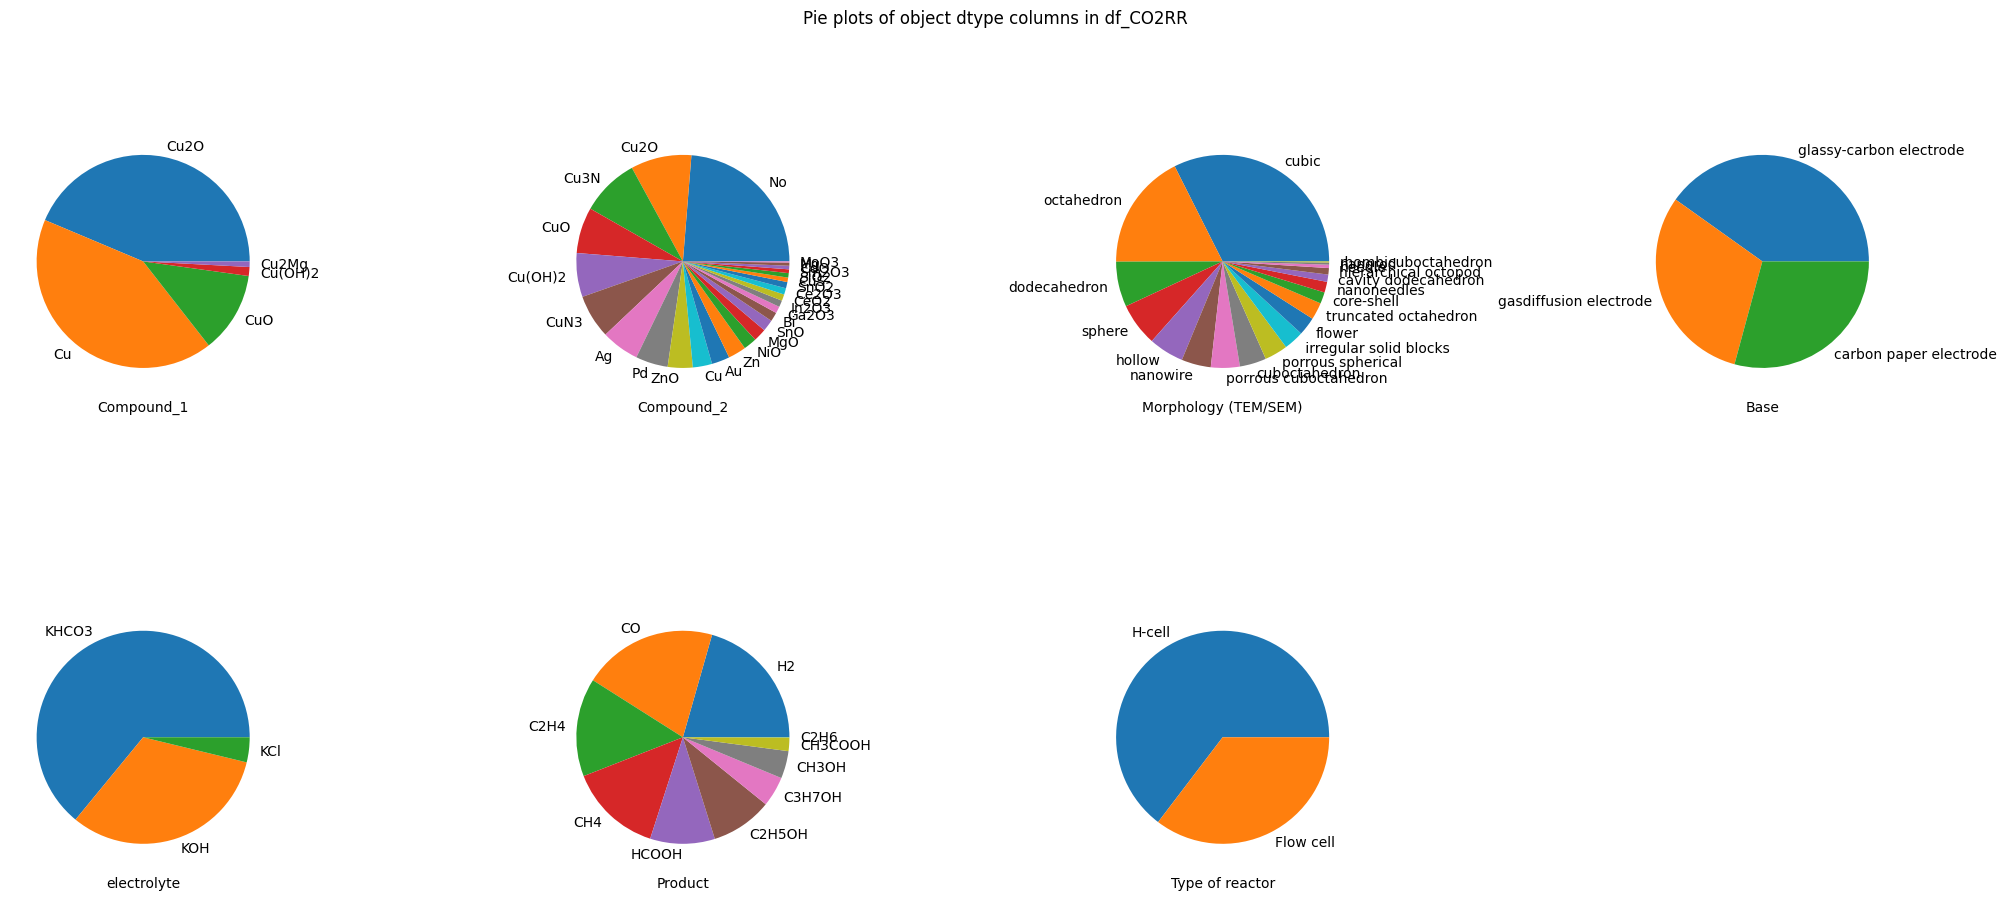

In [31]:
nrows = (len(obj_col_for_an) // 4) + (1 if len(obj_col_for_an) % 4 != 0 else 0)
fig, ax = plt.subplots(nrows, 4, figsize=(20, 10))
ax = ax.flatten()

for i, col in enumerate(obj_col_for_an):
    ax[i].pie(fe_cl[col].value_counts(), labels=fe_cl[col].unique())
    ax[i].set_xlabel(col)

# Hide any unused subplots
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

fig.suptitle("Pie plots of object dtype columns in df_CO2RR")
plt.tight_layout()
plt.show()

In [32]:
prod_dict = fe_cl["Product"].value_counts().to_dict()
to_use = [prod for prod, value in prod_dict.items() if value / len(fe_cl) > 0.01]

prod_to_use = fe_cl["Product"].isin(to_use)
fe_cl = fe_cl[prod_to_use]

In [33]:
products = fe_cl["Product"].unique()

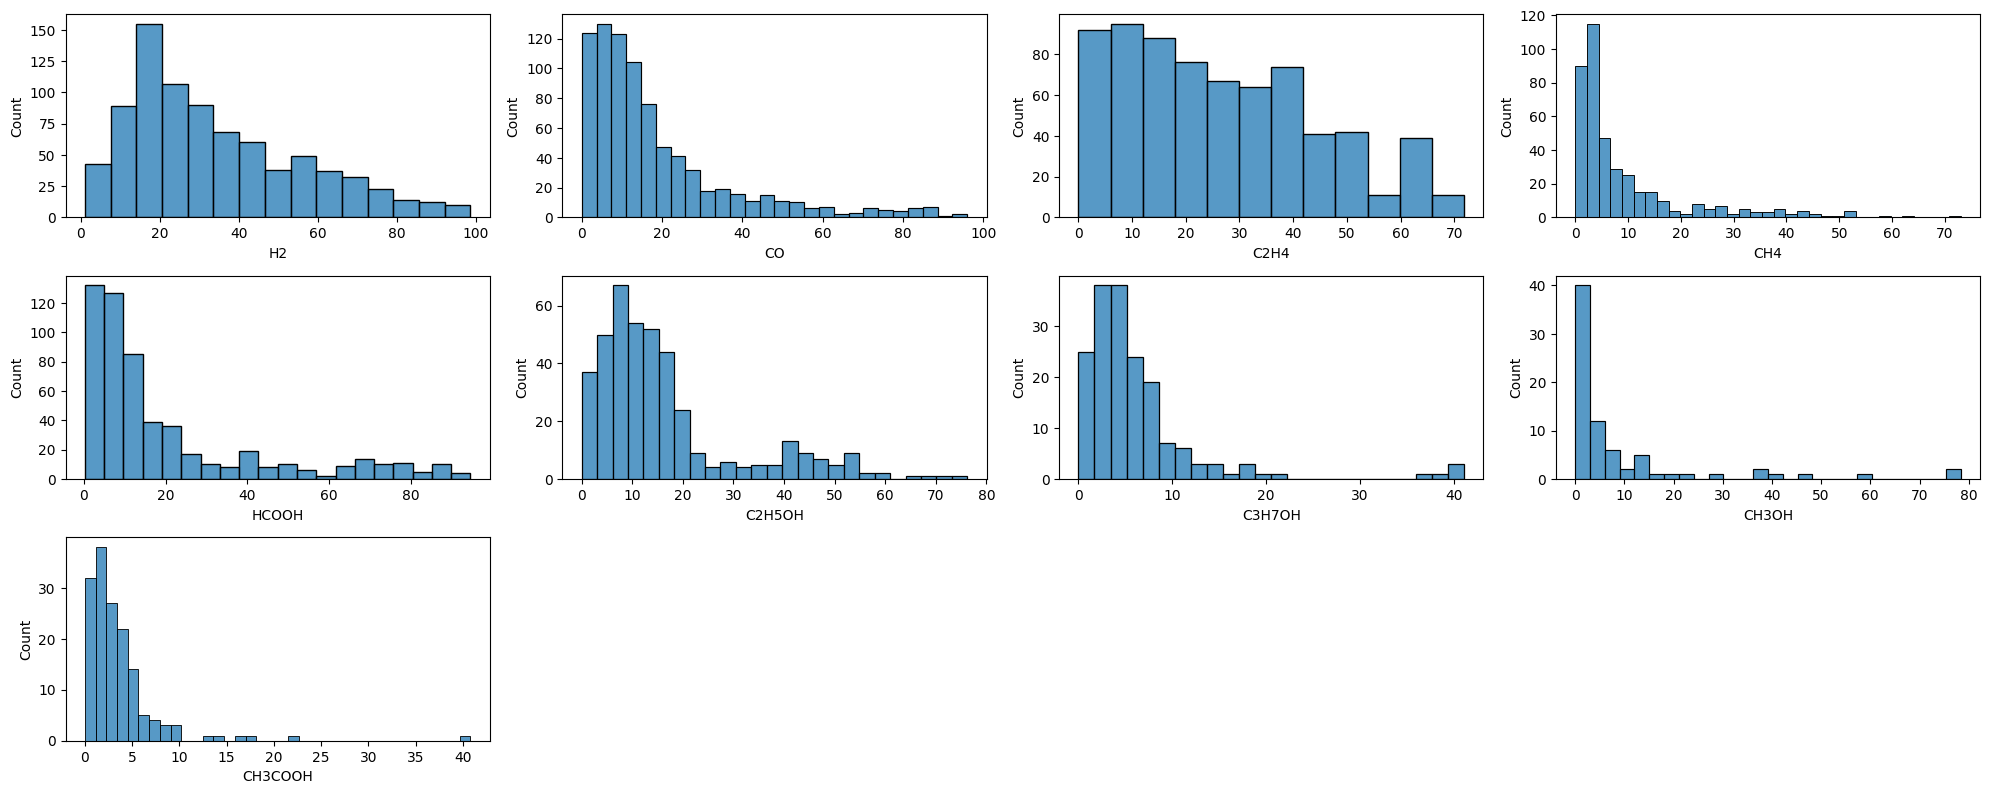

[<Axes: xlabel='H2', ylabel='Count'> <Axes: xlabel='CO', ylabel='Count'>
 <Axes: xlabel='C2H4', ylabel='Count'>
 <Axes: xlabel='CH4', ylabel='Count'>
 <Axes: xlabel='HCOOH', ylabel='Count'>
 <Axes: xlabel='C2H5OH', ylabel='Count'>
 <Axes: xlabel='C3H7OH', ylabel='Count'>
 <Axes: xlabel='CH3OH', ylabel='Count'>
 <Axes: xlabel='CH3COOH', ylabel='Count'> <Axes: > <Axes: > <Axes: >]


In [34]:
num_products = len(products)
nrows = (num_products // 4) + (1 if num_products % 4 != 0 else 0)
fig, ax = plt.subplots(nrows, 4, figsize=(20, 8))
ax = ax.flatten()

for i, prod in enumerate(products):
  sns.histplot(data=fe[fe["Product"] == prod]["FE, %"], ax=ax[i])
  ax[i].set_xlabel(prod)

for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()
print(ax)

# Descriptors creating

## Morphology encoding

In [35]:
fe_cl["Morphology (TEM/SEM)"].unique()

array(['cubic', 'octahedron', 'dodecahedron', 'sphere', 'hollow',
       'nanowire', 'porrous cuboctahedron', 'cuboctahedron',
       'porrous spherical', ' irregular solid blocks', 'flower',
       'truncated octahedron', 'core-shell', 'nanoneedles',
       'cavity dodecahedron', 'hierarchical octopod', 'needle', 'nanorod',
       'rhombicuboctahedron'], dtype=object)

In [36]:
morph_encoding = {'porrous spherical': 'sphere',
                'porrous cuboctahedron': 'cuboctahedron',
                'needle': 'nanowire',
                'nanoneedles': 'nanowire',
                'flower': 'hierarchical octopod',
                'nanorod': 'nanowire'
                }
morph_encoding.items()

dict_items([('porrous spherical', 'sphere'), ('porrous cuboctahedron', 'cuboctahedron'), ('needle', 'nanowire'), ('nanoneedles', 'nanowire'), ('flower', 'hierarchical octopod'), ('nanorod', 'nanowire')])

In [37]:
for old, new in morph_encoding.items():
    fe_cl = fe_cl.replace(old, new)


In [38]:
rod_length_av_max = fe_cl[fe_cl["Morphology (TEM/SEM)"] == "nanowire"]["length aver (nm)"].max()
rod_length_max_max = fe_cl[fe_cl["Morphology (TEM/SEM)"] == "nanowire"]["length max (nm)"].max()
rod_length_min_max = fe_cl[fe_cl["Morphology (TEM/SEM)"] == "nanowire"]["length min (nm)"].max()

mask = fe_cl["Morphology (TEM/SEM)"] == "nanowire"

fe_cl.loc[mask, "length aver (nm)"] = fe_cl.loc[mask, "length aver (nm)"].fillna(rod_length_av_max)
fe_cl.loc[mask, "length max (nm)"] = fe_cl.loc[mask, "length max (nm)"].fillna(rod_length_max_max)
fe_cl.loc[mask, "length min (nm)"] = fe_cl.loc[mask, "length min (nm)"].fillna(rod_length_max_max)

In [39]:
check_empty(fe_cl)

<class 'pandas.core.frame.DataFrame'>
Index: 3696 entries, 0 to 3696
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   width min (nm)   3640 non-null   float64
 1   width max (nm)   3640 non-null   float64
 2   length min (nm)  3640 non-null   float64
 3   length max (nm)  3640 non-null   float64
dtypes: float64(4)
memory usage: 144.4 KB


In [40]:
def process_missing_measurement(df, target_column):
    """
    Универсальная функция для обработки пропусков в колонках размеров
    target_column: название колонки с пропусками (например, 'ширина минимальная мм')
    """
    # 1. Определяем связанные колонки
    average_col = target_column.replace('min', 'aver').replace('max', 'aver')
    
    # Проверяем наличие необходимых колонок
    for col in [target_column, average_col, 'Morphology (TEM/SEM)']:
        if col not in df.columns:
            raise ValueError(f"Колонка {col} не найдена в DataFrame")

    # 2. Находим доминирующий класс морфологии с пропусками
    missing_mask = df[target_column].isna()
    if not missing_mask.any():
        return df  # Пропусков нет
    
    morphology_class = df.loc[missing_mask, 'Morphology (TEM/SEM)'].mode()
    if morphology_class.empty:
        raise ValueError(f"Не удалось определить класс морфологии для {target_column}")
    morphology_class = morphology_class[0]

    # 3. Расчет коэффициента преобразования
    class_mask = df['Morphology (TEM/SEM)'] == morphology_class
    valid_data = df[class_mask].dropna(subset=[target_column])
    
    if valid_data.empty:
        raise ValueError(f"Нет данных для расчета: класс {morphology_class} ({target_column})")

    valid_data['diff_ratio'] = (valid_data[average_col] - valid_data[target_column]) / valid_data[target_column]
    average_diff = valid_data['diff_ratio'].mean()
    
    # 4. Заполнение пропусков
    conversion_factor = 1 / (1 + average_diff)
    to_fill_mask = class_mask & missing_mask
    
    df.loc[to_fill_mask, target_column] = df.loc[to_fill_mask, average_col] * conversion_factor
    return df

# Автоматическая обработка всех параметров
parameters = ['length', 'width']
extrema_types = ['min', 'max']

for param in parameters:
    for extrema in extrema_types:
        target_col = f"{param} {extrema} (nm)"
        if target_col in fe_cl.columns:
            print(f"Обработка: {target_col}")
            try:
                fe_cl = process_missing_measurement(fe_cl, target_col)
            except Exception as e:
                print(f"Ошибка при обработке {target_col}: {str(e)}")
        else:
            print(f"Колонка {target_col} отсутствует - пропуск")

# Визуализация результатов
print("\nРезультаты заполнения пропусков:")
for param in parameters:
    print(f"\n{param.capitalize():^30}")
    print(fe_cl[[f"{param} min (nm)", f"{param} aver (nm)", f"{param} max (nm)"]].describe())

Обработка: length min (nm)
Обработка: length max (nm)
Обработка: width min (nm)
Обработка: width max (nm)

Результаты заполнения пропусков:

            Length            
       length min (nm)  length aver (nm)  length max (nm)
count      3696.000000       3696.000000      3696.000000
mean        350.630683        466.868647       636.903928
std         753.829276        829.039746      1109.103718
min           1.840000          2.280000         2.720000
25%          25.000000         34.530000        60.000000
50%         115.000000        175.230000       220.000000
75%         278.000000        355.960000       480.330000
max        5000.000000       4000.000000      5000.000000

            Width             
       width min (nm)  width aver (nm)  width max (nm)
count     3696.000000      3696.000000     3696.000000
mean       251.520307       340.820208      453.326600
std        548.495155       669.982950      853.684145
min          1.840000         2.280000        2.720000

In [41]:
check_empty(fe_cl)

<class 'pandas.core.frame.DataFrame'>
Index: 3696 entries, 0 to 3696
Empty DataFrame


In [42]:
def f_cubic(x1, x2):
    volume = np.power(x1, 3)
    d1 = 2 * np.sqrt(3) / 2 * x1
    d2 = 2 * np.sqrt(3) / 2 * x2
    sphere_vol = f_sphere(d1, d2)[0]
    return volume, volume / sphere_vol

def f_sphere(x1, x2):
    volume = (4/3) * np.pi * x1 * x1 * x2 / 8
    sphere_vol = volume

    return volume, volume / sphere_vol

def f_octahedron(x1, x2):
    volume = 2 * 1 / 3 * x1 * x1 * x2 / 2

    sphere_vol = f_sphere(x1, x2)[0]

    return volume, volume / sphere_vol

def f_dodecahedron(x1, x2):
    a = x1 / 2 / 1.4012
    volume = 7.66  * np.power(a, 3)

    sphere_vol = f_sphere(x1, x2)[0]

    return volume, volume / sphere_vol

def f_nanowire(x1, x2):
    r = x1 / 2
    volume = np.pi * r * r * x2
    d2 = np.sqrt(x1 * x1 + x2 * x2)
    sphere_vol = f_sphere(d2, 2 * r)[0]

    return volume, volume / sphere_vol

def f_cuboctahedron(x1, x2):
    a = x1 / 2
    volume = 5 / 3 * np.sqrt(2) * np.power(a, 3)

    sphere_vol = f_sphere(x1, x2)[0]

    return volume, volume / sphere_vol

def f_octopod(x1, x2):
    volume_f = 2 * 4 * x2 * x2 * (x2 - x1) / 2
    volume_conn = 3 * np.power(x2, 3)
    volume = volume_f + volume_conn

    d1 = np.sqrt(x1 * x1 + (3 * x2) * (3 * x2))
    d2 = np.sqrt(x1 * x1 + (3 * x2) * (3 * x2))
    sphere_vol = f_sphere(d1, d2)[0]

    return volume, volume / sphere_vol

def f_truncated_octahedron(x1, x2):
    a = x1 / 2 / 1.58114
    volume = 8 * np.sqrt(2) * np.power(a, 3)

    sphere_vol = f_sphere(x1, x1)[0]
    return volume, volume / sphere_vol

def f_cav_dodecahedron(x1, x2):
    volume = (f_dodecahedron(x1, x2)[0] - f_dodecahedron(x1 / 2, x2 / 2)[0]) / 2

    sphere_vol = f_sphere(x1, x2)[0] / 2 

    return volume, volume / sphere_vol

def f_rhombicuboctahedron(x1, x2):
    a = x1 / 1.39897 / 2

    volume = (12 + 10 * np.sqrt(2)) / 3 * np.power(a, 3)

    sphere_vol = f_sphere(x1, x2)[0] 

    return volume, volume / sphere_vol


In [43]:
fe_cl["Morphology (TEM/SEM)"].unique()

array(['cubic', 'octahedron', 'dodecahedron', 'sphere', 'hollow',
       'nanowire', 'cuboctahedron', ' irregular solid blocks',
       'hierarchical octopod', 'truncated octahedron', 'core-shell',
       'cavity dodecahedron', 'rhombicuboctahedron'], dtype=object)

In [44]:
len(fe_cl[fe_cl["Morphology (TEM/SEM)"] == " irregular solid blocks"])

96

In [45]:
ir_blocks = fe_cl[fe_cl["Morphology (TEM/SEM)"] == " irregular solid blocks"].index

In [46]:
fe_cl = fe_cl.drop(ir_blocks)

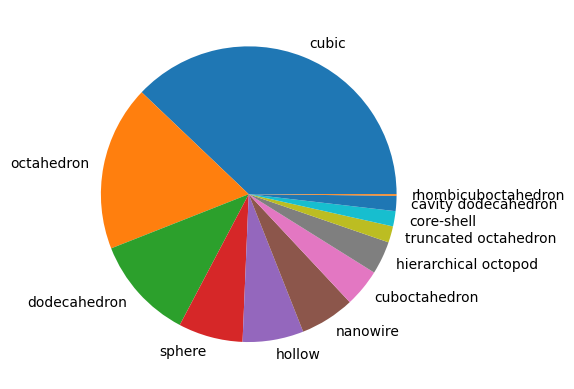

In [47]:
plt.pie(fe_cl["Morphology (TEM/SEM)"].value_counts(), labels=fe_cl["Morphology (TEM/SEM)"].unique())
plt.show()

In [48]:
morph_func = {
    "cubic": f_cubic,
    "octahedron": f_octahedron,
    "dodecahedron": f_dodecahedron,
    "sphere": f_sphere,
    "hollow": f_sphere,
    "nanowire": f_nanowire,
    "cuboctahedron": f_cuboctahedron,
    "hierarchical octopod": f_octopod,
    "truncated octahedron": f_truncated_octahedron,
    "core-shell": f_sphere,
    'cavity dodecahedron': f_cav_dodecahedron,
    'rhombicuboctahedron': f_rhombicuboctahedron   
}

error_list = []
for morph in fe_cl["Morphology (TEM/SEM)"].unique():
    if morph not in morph_func.keys():
        error_list.append(morph)

if len(error_list) != 0:
    raise ValueError(f"You need to describe next types of morhology: {error_list}")


In [49]:
for func in morph_func.values():
    if np.shape(func(1,1)) != (2,):
        raise ValueError(f"Функция {func} возвращает неправильное количество аргументов")

In [50]:
fe_cl.columns

Index(['DOI', 'Article name', 'Compound_1', 'Compound_2',
       'Cat./Support ratio, % (at)', 'Morphology (TEM/SEM)', 'Pore size, nm',
       'width min (nm)', 'width aver (nm)', 'width max (nm)',
       'length min (nm)', 'length aver (nm)', 'length max (nm)', 'Cu, % (at.)',
       'Cu+, % (at.)', 'Cu(2+), % (at.)', 'Base', 'electrolyte', 'conc, M',
       'pH', 'RHE vs V', 'Product', 'FE, %', 'Time, h', 'Type of reactor',
       'Loading, μg/cm2', 'Add_carbon, %', 'Surface area of electrode, cm2',
       'Flow rate CO2, ml/min'],
      dtype='object')

In [51]:
# Функция для расчета объема на основе морфологии
def calculate_av_volume(row):
    morphology = row["Morphology (TEM/SEM)"]
    size_1 = row["width aver (nm)"]
    size_2 = row["length aver (nm)"]
    if morphology in morph_func:
        return morph_func[morphology](size_1, size_2)[0]
    else:
        return None  # Если морфология не найдена в словаре
    

def calculate_av_sphere_volume(row):
    morphology = row["Morphology (TEM/SEM)"]
    size_1 = row["width aver (nm)"]
    size_2 = row["length aver (nm)"]
    if morphology in morph_func:
        return morph_func[morphology](size_1, size_2)[1]
    else:
        return None  # Если морфология не найдена в словаре

def calculate_min_volume(row):
    morphology = row["Morphology (TEM/SEM)"]
    size_1 = row["width min (nm)"]
    size_2 = row["length min (nm)"]
    if morphology in morph_func:
        return morph_func[morphology](size_1, size_2)[0]
    else:
        return None  # Если морфология не найдена в словаре
    
def calculate_max_volume(row):
    morphology = row["Morphology (TEM/SEM)"]
    size_1 = row["width max (nm)"]
    size_2 = row["length max (nm)"]
    if morphology in morph_func:
        return morph_func[morphology](size_1, size_2)[0]
    else:
        return None  # Если морфология не найдена в словаре


# Применяем функцию к каждой строке датафрейма
fe_cl["Av_volume, mkm^3"] = fe_cl.apply(calculate_av_volume, axis=1) / np.power(1000, 3)
fe_cl["Ratio_sphere_volume"] = fe_cl.apply(calculate_av_sphere_volume, axis=1)

fe_cl["Min_volume, mkm^3"] = fe_cl.apply(calculate_min_volume, axis=1) / np.power(1000, 3)

fe_cl["Max_volume, mkm^3"] = fe_cl.apply(calculate_max_volume, axis=1) / np.power(1000, 3)


# Выводим результат
fe_cl.head()

,DOI,Article name,Compound_1,Compound_2,"Cat./Support ratio, % (at)",Morphology (TEM/SEM),"Pore size, nm",width min (nm),width aver (nm),width max (nm),...,"Time, h",Type of reactor,"Loading, μg/cm2","Add_carbon, %","Surface area of electrode, cm2","Flow rate CO2, ml/min","Av_volume, mkm^3",Ratio_sphere_volume,"Min_volume, mkm^3","Max_volume, mkm^3"
0,https://doi.org/10.1016/j.apsusc.2023.159243,c-Cu2O,Cu2O,No,100.0,cubic,0.0,459.5,810.75,1162.0,...,1.0,H-cell,713.19,0.0,0.2,20.0,0.532919,0.367553,0.097019,1.568984
1,https://doi.org/10.1016/j.apsusc.2023.159243,c-Cu2O,Cu2O,No,100.0,cubic,0.0,459.5,810.75,1162.0,...,1.0,H-cell,713.19,0.0,0.2,20.0,0.532919,0.367553,0.097019,1.568984
2,https://doi.org/10.1016/j.apsusc.2023.159243,o-Cu2O,Cu2O,No,100.0,octahedron,0.0,805.0,1204.00,1603.0,...,1.0,H-cell,713.19,0.0,0.2,20.0,0.616763,0.636620,0.207735,1.362835
3,https://doi.org/10.1016/j.apsusc.2023.159243,o-Cu2O,Cu2O,No,100.0,octahedron,0.0,805.0,1204.00,1603.0,...,1.0,H-cell,713.19,0.0,0.2,20.0,0.616763,0.636620,0.207735,1.362835
4,https://doi.org/10.1016/j.apsusc.2023.159243,o-Cu2O,Cu2O,No,100.0,octahedron,0.0,805.0,1204.00,1603.0,...,1.0,H-cell,713.19,0.0,0.2,20.0,0.616763,0.636620,0.207735,1.362835


In [52]:
fe_cl[fe_cl["Ratio_sphere_volume"] > 1][["Morphology (TEM/SEM)", "Ratio_sphere_volume"]].drop_duplicates()

,Morphology (TEM/SEM),Ratio_sphere_volume


In [53]:
fe_cl = fe_cl.reset_index(drop=True)
fe_cl.shape

(3600, 33)

In [54]:
fe_morph = fe_cl[["Av_volume, mkm^3", "Ratio_sphere_volume", "Min_volume, mkm^3", "Max_volume, mkm^3"]]

## Materials project API

In [55]:
from mp_api.client import MPRester

g:\python_projects\CO2RR_Tai\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [56]:
# We sum compounds from two columns, which describe formulas of corresponding element

mat_array = set(fe_cl['Compound_1'].unique())
mat_array = mat_array | set(fe_cl['Compound_2'].unique())
mat_array.remove("No")

In [57]:
# Set of crystal strucures of compounds. This is information is essential for getting actual properties

compounds = [['Cu2O', 'Pn-3m'],
 ['Cu', 'Fm-3m'],
 ['CuO', 'C2/c'],
 ['Cu3N', 'Pm-3m'],
 ['Cu(OH)2', 'Cmc2_1'],
 ['Ag', 'Fm-3m'],
 ['Pd', 'Fm-3m'],
 ['ZnO', 'P6_3mc'],
 ['In', 'I4/mmm'],
 ['In2O3', 'R-3c'],
 ['CuCl', 'F-43m'],
 ['Au', 'Fm-3m'],
 ['Zn', 'P6_3/mmc'],
 ['SnO', 'P4/nmm'],
 ['Ga2O3', 'C2/m'],
 ['NiO', 'Fm-3m'],
 ['MgO', 'Fm-3m'],
 ['Bi', 'C2/m'],
 ['CuN3', 'I4_1/a'],
 ['Ce', 'P6_3/mmc'],
 ['Ce2O3', 'P-3m1'],
 ["CeO2", 'Fm-3m'],
 ["CdO", 'Fm-3m'],
 ["MoO3", "P2_1/c"],
 ["Sm2O3", "Ia-3"],
 ["CuS", 'P6_3/mmc'],
 ["SnO2", "P4_2/mnm"],
 ["Cu2Mg", "Fd-3m"],
 ["SiO2", "P3_221"],
 ["Mg", 'P6_3/mmc']]

In [58]:
# As crytal structure is manually added information, we set an alert if we got a new compound in the database
comps_in_dict = [comp[0] for comp in compounds]
error_list = list()

for df_mat in mat_array:
    if df_mat not in comps_in_dict:
        error_list.append(df_mat)
if len(error_list) != 0:
    raise ValueError(f"You need to add to array an information about these materials: {error_list}")

In [59]:
# with MPRester("bQ6RzBnlGB636PaKj3ewowMI0RN3gjv6") as mpr:
#     # We limit our search by necessary space group, which we defined upper
#     docs = mpr.materials.summary.search(
#         formula='Sm2O3', all_fields=True, theoretical=False
#     )

#     # We point the first result if the search. If result consists from one result, it will be also list of lists
#     doc = docs[1]
#     print(docs)

In [60]:
# doc.structure

In [61]:
# We will save results of our search in separate list of lists
res = list()
# There we point needed descriptors from MP API
properties = ["efermi", "density_atomic", "total_magnetization_normalized_formula_units", "energy_above_hull", "energy_per_atom", 'volume', 'band_gap', ]
df_columns = ["Name"]
# We form columns of our dataframe, which will represent results of search
df_columns.extend(properties)

# We use standard API form. You can get your personal key at the site of Materials Project
with MPRester("bQ6RzBnlGB636PaKj3ewowMI0RN3gjv6") as mpr:
    for comp, system in compounds:
        # We limit our search by necessary space group, which we defined upper
        docs = mpr.materials.summary.search(
            formula=comp, all_fields=True, theoretical=False, spacegroup_symbol=system
        )

        # We point the first result if the search. If result consists from one result, it will be also list of lists
        doc = docs[0]

        # We form a buffer for our search for this current compound
        values = [comp]
        # We exclude properties from the result list
        values.extend([getattr(doc, prop) for prop in properties])

        # There we add the buffer list to the main list of lists
        res.append(values)
        print(f"{doc.formula_pretty}, {doc.symmetry.symbol}, {doc.symmetry.crystal_system}, {doc.material_id}, {doc.efermi}") 

Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


Cu2O, Pn-3m, Cubic, mp-361, 4.17791244


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 1028.52it/s]


Cu, Fm-3m, Cubic, mp-30, 7.51858683


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


CuO, C2/c, Monoclinic, mp-704645, 4.72796063


Retrieving SummaryDoc documents: 100%|██████████| 2/2 [00:00<?, ?it/s]


Cu3N, Pm-3m, Cubic, mp-13480, 6.14131032


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]


Cu(HO)2, Cmc2_1, Orthorhombic, mp-505105, 2.1667273


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


Ag, Fm-3m, Cubic, mp-124, 3.94067991


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


Pd, Fm-3m, Cubic, mp-2, 4.47959619


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


ZnO, P6_3mc, Hexagonal, mp-2133, 0.8923141


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


In, I4/mmm, Tetragonal, mp-1055994, 6.58636739


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


In2O3, R-3c, Trigonal, mp-22323, 5.14775141


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


CuCl, F-43m, Cubic, mp-22914, 3.79302604


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 1014.83it/s]


Au, Fm-3m, Cubic, mp-81, 5.84744474


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


Zn, P6_3/mmc, Hexagonal, mp-79, 3.29833257


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


SnO, P4/nmm, Tetragonal, mp-2097, 6.30205676


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


Ga2O3, C2/m, Monoclinic, mp-886, 2.06965603


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


NiO, Fm-3m, Cubic, mp-19009, 5.87177732


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


MgO, Fm-3m, Cubic, mp-1265, 2.7374354


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


Bi, C2/m, Monoclinic, mp-23157, 6.47640097


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


CuN3, I4_1/a, Tetragonal, mp-504768, 1.44159893


Retrieving SummaryDoc documents: 100%|██████████| 2/2 [00:00<?, ?it/s]


Ce, P6_3/mmc, Hexagonal, mp-20372, 9.06269943


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


Ce2O3, P-3m1, Trigonal, mp-2721, 8.41138892


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


CeO2, Fm-3m, Cubic, mp-20194, 5.05743538


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 998.88it/s]


CdO, Fm-3m, Cubic, mp-1132, 1.54992079


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


MoO3, P2_1/c, Monoclinic, mp-18856, 0.42873088000000004


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


Sm2O3, Ia-3, Cubic, mp-218, 1.27052682


Retrieving SummaryDoc documents: 100%|██████████| 2/2 [00:00<?, ?it/s]


CuS, P6_3/mmc, Hexagonal, mp-504, 5.49246722


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


SnO2, P4_2/mnm, Tetragonal, mp-856, 5.59411961


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]


MgCu2, Fd-3m, Cubic, mp-1038, 5.6643077


Retrieving SummaryDoc documents: 100%|██████████| 2/2 [00:00<?, ?it/s]


SiO2, P3_221, Trigonal, mp-640917, 2.69161299


Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]

Mg, P6_3/mmc, Hexagonal, mp-153, 2.03846677


In [62]:
df_mpapi_res = pd.DataFrame(data=res, columns=df_columns)
df_mpapi_res = df_mpapi_res.set_index("Name")
# As we coded catalysts with no additional compound as No, we add this row to MP API dataset
no_row = (len(df_mpapi_res.columns)*[0])
df_mpapi_res.loc["No"] = no_row

df_mpapi_res

,efermi,density_atomic,total_magnetization_normalized_formula_units,energy_above_hull,energy_per_atom,volume,band_gap
Name,,,,,,,
Cu2O,4.177912,12.764485,0.000000e+00,0.000000,-5.026630,76.586908,0.5127
Cu,7.518587,11.445999,2.000000e-07,0.000000,-10.846796,11.445999,0.0000
CuO,4.727961,11.121388,6.916000e-04,0.000265,-5.466114,44.485552,0.0000
Cu3N,6.141310,10.622479,1.956000e-04,0.801885,-9.615400,42.489916,0.0000
Cu(OH)2,2.166727,8.701898,9.999901e-01,0.097853,-5.204359,87.018977,0.0000
Ag,3.940680,17.285231,9.000000e-07,0.002127,-21.353750,17.285231,0.0000
Pd,4.479596,15.027995,3.851734e-01,0.000000,-22.960454,15.027995,0.0000
ZnO,0.892314,11.849287,0.000000e+00,0.000000,-4.894751,47.397148,0.7227
In,6.586367,26.484932,0.000000e+00,0.004490,-22.574101,26.484932,0.0000


In [63]:
# We form a dictionary, which will help us to form a separate df of mpapi properties
mpapi_dict = df_mpapi_res.T.to_dict("list")

In [64]:
fe_mpapi = pd.DataFrame()
descr_col = list(df_mpapi_res.columns)

c_descr = list()
for i in fe_cl["Compound_1"].to_list():
    c_descr.append(mpapi_dict[i])
c_descr = np.array(c_descr).transpose()

for i in range(len(descr_col)):
    fe_mpapi["1_"+descr_col[i]] = c_descr[i]

s_descr = list()
for i in fe_cl["Compound_2"].to_list():
    s_descr.append(mpapi_dict[i])
s_descr = np.array(s_descr).transpose()

for i in range(len(descr_col)):
    fe_mpapi["2_"+descr_col[i]] = s_descr[i]


fe_mpapi

,1_efermi,1_density_atomic,1_total_magnetization_normalized_formula_units,1_energy_above_hull,1_energy_per_atom,1_volume,1_band_gap,2_efermi,2_density_atomic,2_total_magnetization_normalized_formula_units,2_energy_above_hull,2_energy_per_atom,2_volume,2_band_gap
0,4.177912,12.764485,0.000000,0.000000,-5.026630,76.586908,0.5127,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0000
1,4.177912,12.764485,0.000000,0.000000,-5.026630,76.586908,0.5127,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0000
2,4.177912,12.764485,0.000000,0.000000,-5.026630,76.586908,0.5127,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0000
3,4.177912,12.764485,0.000000,0.000000,-5.026630,76.586908,0.5127,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0000
4,4.177912,12.764485,0.000000,0.000000,-5.026630,76.586908,0.5127,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,4.727961,11.121388,0.000692,0.000265,-5.466114,44.485552,0.0000,5.59412,12.136907,0.0,0.0,-6.742647,72.821439,0.6519
3596,4.727961,11.121388,0.000692,0.000265,-5.466114,44.485552,0.0000,5.59412,12.136907,0.0,0.0,-6.742647,72.821439,0.6519
3597,4.727961,11.121388,0.000692,0.000265,-5.466114,44.485552,0.0000,5.59412,12.136907,0.0,0.0,-6.742647,72.821439,0.6519
3598,4.727961,11.121388,0.000692,0.000265,-5.466114,44.485552,0.0000,5.59412,12.136907,0.0,0.0,-6.742647,72.821439,0.6519


<Axes: >

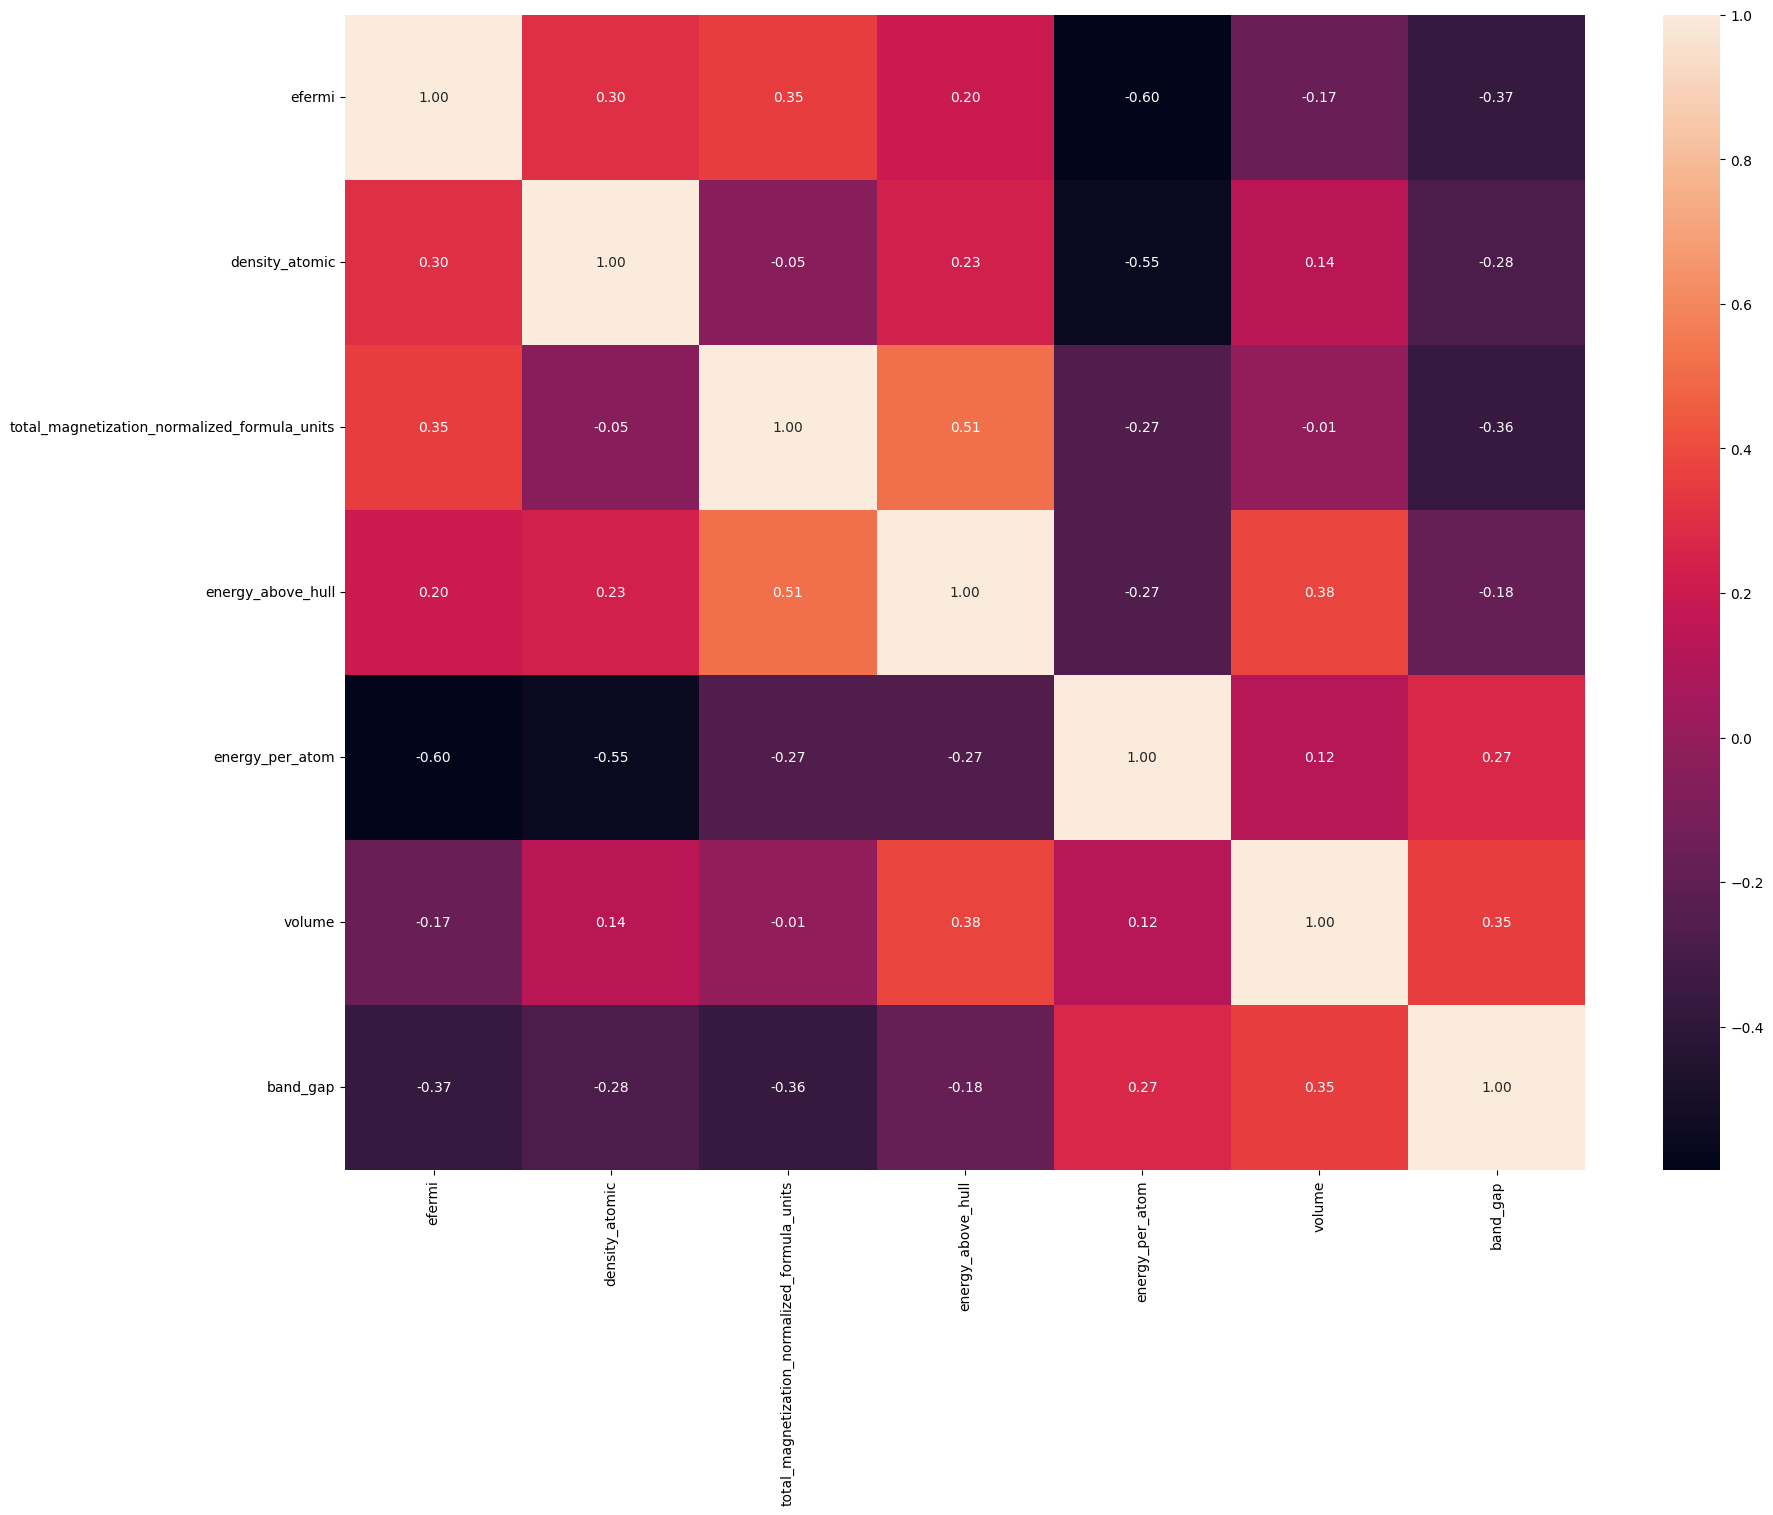

In [65]:
# Let's check correlation of the MP API descriptors by heatmap

num_col = df_mpapi_res.select_dtypes(include=["float64", "int64"]).columns

plt.figure(figsize=(20, 15))
sns.heatmap(data=df_mpapi_res[num_col].corr("spearman"), annot=True, fmt=".2f", annot_kws={"size": 10})

## RDKIT for products

In [66]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

import pubchempy as pcp

In [67]:
product_data = dict()
product_data["Compound"] = list(fe_cl["Product"].unique())
product_data["isomeric_smiles"] = list()

In [68]:
# List of SMILEs
control_list = {'C2H4': 'C=C',
 'H2': '[HH]',
 'CO': '[C-]#[O+]',
 'C2H5OH': 'CCO',
 'CH4': 'C',
 'HCOOH': 'C(=O)O',
 'C3H7OH': 'CC(C)O',
 'CH3OH': 'CO',
 'CH3COOH': 'CC(=O)O'}

In [69]:
# If compound not in control list, we find its SMILES with pubchempy function
for comp in product_data["Compound"]:
    print(comp)
    if comp not in control_list.keys():
        compound = pcp.get_compounds(comp, "formula")[0]
        product_data["isomeric_smiles"].append(compound.isomeric_smiles)
    else:
        product_data["isomeric_smiles"].append(control_list[comp])

H2
CO
C2H4
CH4
HCOOH
C2H5OH
C3H7OH
CH3OH
CH3COOH


In [70]:
df_products = pd.DataFrame(data=product_data)

In [71]:
mol_to_smiles = df_products.set_index("Compound").T.to_dict("list")
mol_to_smiles = {mol: sm[0] for mol, sm in mol_to_smiles.items()}

In [72]:
# Function returns high-correlated columns to drop from dataframe
def to_drop_corr_col(df, val):
    corr_matrix = df.corr(method="spearman").abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > val)]
    return to_drop

In [73]:

descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
get_descriptors = rdMolDescriptors.Properties(descriptor_names)
num_descriptors = len(descriptor_names)

# array to collect information about properties of compounds
descriptors_set = np.empty((0, num_descriptors), float)

for value in df_products["isomeric_smiles"]:
    molecule = Chem.MolFromSmiles(value)
    descriptors = np.array(get_descriptors.ComputeProperties(molecule)).reshape((-1,num_descriptors))
    descriptors_set = np.append(descriptors_set, descriptors, axis=0)

df_product_desc = pd.DataFrame(data=descriptors_set, columns=descriptor_names)

# We drop descriptors with only one value (non-variative descirptors)
df_product_desc = df_product_desc.loc[:, df_product_desc.nunique() > 1]

# We drop high -correlated descriptors (this situation is normal for RDkit)
df_product_desc = df_product_desc.drop(to_drop_corr_col(df_product_desc, 0.9), axis=1)

[22:39:33] WARNING: not removing hydrogen atom without neighbors


<Axes: >

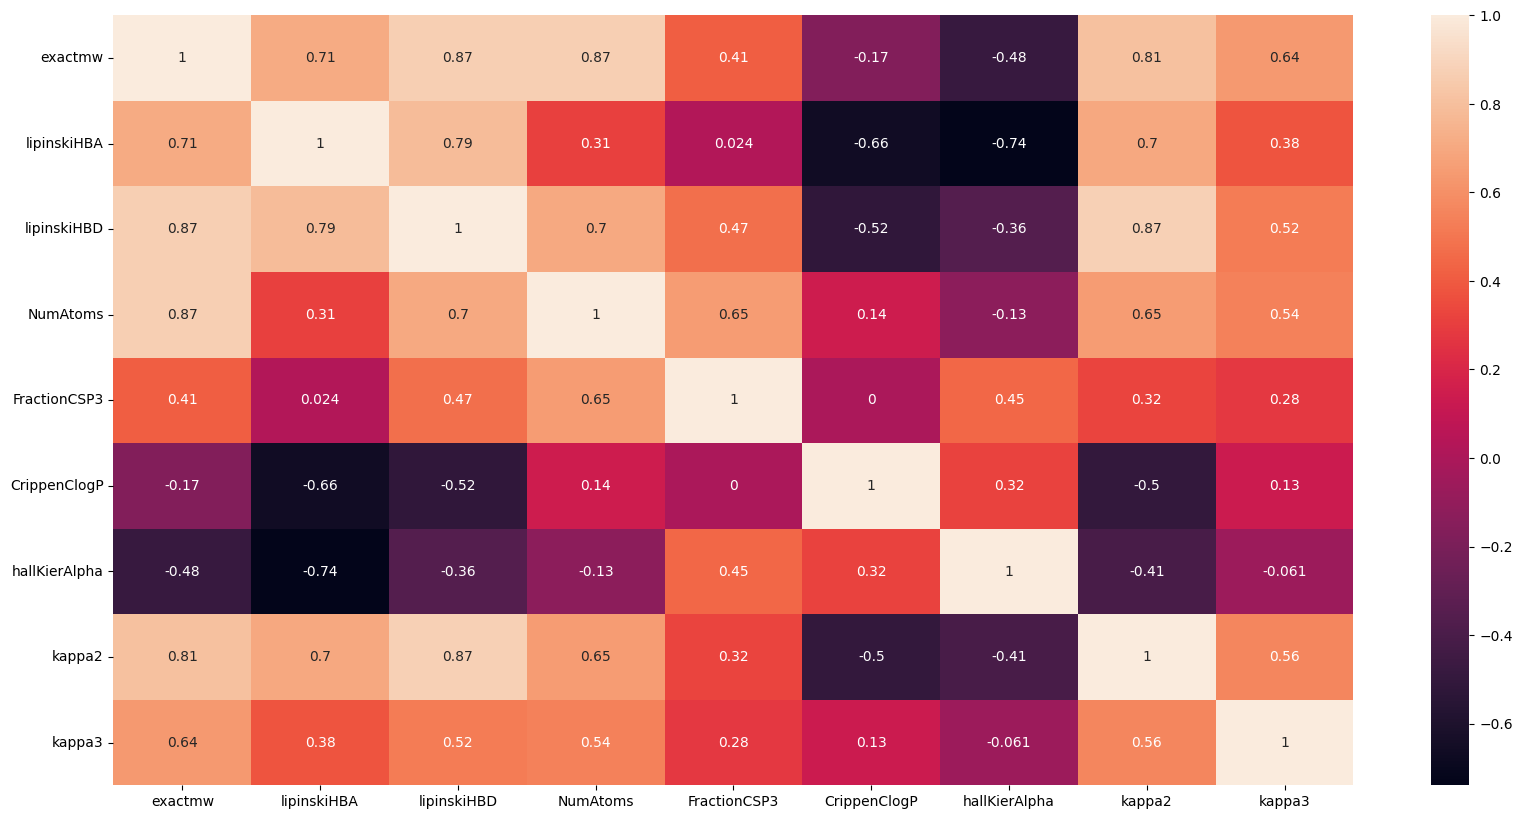

In [74]:
plt.figure(figsize=(20,10))
sns.heatmap(df_product_desc.corr(method="spearman"), annot=True)

In [75]:
# Code to skip warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# We save descriptors, which we used previously
descriptor_names = df_product_desc.columns
get_descriptors = rdMolDescriptors.Properties(descriptor_names)
num_descriptors = len(descriptor_names)
descriptors_set = np.empty((0, num_descriptors), float)

for value in fe_cl["Product"]:
    value = mol_to_smiles[value]
    molecule = Chem.MolFromSmiles(value)
    descriptors = np.array(get_descriptors.ComputeProperties(molecule)).reshape((-1,num_descriptors))
    descriptors_set = np.append(descriptors_set, descriptors, axis=0)

fe_product_rdkit = pd.DataFrame(data=descriptors_set, columns=["Product_" + col for col in df_product_desc.columns])

fe_product_rdkit

,Product_exactmw,Product_lipinskiHBA,Product_lipinskiHBD,Product_NumAtoms,Product_FractionCSP3,Product_CrippenClogP,Product_hallKierAlpha,Product_kappa2,Product_kappa3
0,2.015650,0.0,0.0,2.0,0.0,0.24600,0.00,0.00,0.000000
1,27.994915,1.0,0.0,2.0,0.0,-0.03751,-0.26,0.74,-6.106154
2,28.031300,0.0,0.0,6.0,0.0,0.80220,-0.26,0.74,-6.106154
3,2.015650,0.0,0.0,2.0,0.0,0.24600,0.00,0.00,0.000000
4,27.994915,1.0,0.0,2.0,0.0,-0.03751,-0.26,0.74,-6.106154
...,...,...,...,...,...,...,...,...,...
3595,2.015650,0.0,0.0,2.0,0.0,0.24600,0.00,0.00,0.000000
3596,2.015650,0.0,0.0,2.0,0.0,0.24600,0.00,0.00,0.000000
3597,2.015650,0.0,0.0,2.0,0.0,0.24600,0.00,0.00,0.000000
3598,2.015650,0.0,0.0,2.0,0.0,0.24600,0.00,0.00,0.000000


## Reactor and base encoding

In [76]:
from sklearn.preprocessing import OneHotEncoder

In [77]:
encoder_reactor = OneHotEncoder()

encoded_reactor = encoder_reactor.fit_transform(fe_cl[["Type of reactor"]])

fe_encoded_reactor = pd.DataFrame(data=encoded_reactor.toarray(), columns=encoder_reactor.get_feature_names_out(["Type of reactor"])).drop('Type of reactor_Flow cell', axis=1)

fe_encoded_reactor

,Type of reactor_H-cell
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
3595,1.0
3596,1.0
3597,1.0
3598,1.0


In [78]:
encoder_base = OneHotEncoder()

encoded_base = encoder_base.fit_transform(fe_cl[["Base"]])

fe_encoded_base= pd.DataFrame(data=encoded_base.toarray(), columns=encoder_base.get_feature_names_out(["Base"])).drop("Base_glassy-carbon electrode", axis=1)

fe_encoded_base

,Base_carbon paper electrode,Base_gasdiffusion electrode
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
3595,1.0,0.0
3596,1.0,0.0
3597,1.0,0.0
3598,1.0,0.0


## Electrolyte encoding

In [79]:
fe_cl[["electrolyte","conc, M"]].drop_duplicates()

,electrolyte,"conc, M"
0,KHCO3,0.1
474,KOH,1.0
607,KCl,1.0
640,KHCO3,0.5
1373,KOH,2.0
2889,KOH,0.1
2929,KOH,3.0
3313,KHCO3,1.0


In [80]:
comp_split = {"KHCO3": ["K+", "HCO3-"], "KCl": ["K+", "Cl-"], "KOH": ["K+", "OH-"]}

# Values are get from Kadhim M. J., Gamaj M. I. Estimation of the diffusion coefficient and hydrodynamic radius (stokes radius) for inorganic ions in solution depending on molar conductivity as electro-analytical technique-a review //J. Chem. Rev. – 2020. – Т. 2. – №. 3. – С. 182-188.
ion_dict = {
            "ion" : ["K+", "Cl-", "OH-", "HCO3-"],
            "molar_conductance": [73.5, 76.4, 199.1, 44.5],
            "mobility": [7.638, 7.670, 20.210, 4.353],
            "diffusion_coefficient": [1.893, 1.970, 5.192, 1.118],
            "hydr_R_of_ion": [1.295, 1.245, 0.472, 2.193]
            }

In [81]:
df_ions_propert = pd.DataFrame(data=ion_dict)
df_ions_propert

,ion,molar_conductance,mobility,diffusion_coefficient,hydr_R_of_ion
0,K+,73.5,7.638,1.893,1.295
1,Cl-,76.4,7.670,1.970,1.245
2,OH-,199.1,20.210,5.192,0.472
3,HCO3-,44.5,4.353,1.118,2.193


In [82]:
electr_dict = df_ions_propert.set_index("ion").T.to_dict("list")

In [83]:
# We check, if all compounds have corresponding property
electr_type = list(fe_cl["electrolyte"].unique())
for electr in electr_type:
    if electr not in comp_split.keys():
        raise ValueError(f"There is no information abot electrolyete {electr}")

In [84]:
electr_desc_cols = df_ions_propert.set_index("ion").columns

s_descr = list()
for i in fe_cl["electrolyte"].to_list():
    s_descr.append(electr_dict[comp_split[i][1]])
s_descr_c = np.array(s_descr).transpose()

df_cols = ["anion_"+electr_desc_col for electr_desc_col in electr_desc_cols]
fe_electr_coded = pd.DataFrame(data=s_descr, columns=df_cols)
fe_electr_coded

,anion_molar_conductance,anion_mobility,anion_diffusion_coefficient,anion_hydr_R_of_ion
0,44.5,4.353,1.118,2.193
1,44.5,4.353,1.118,2.193
2,44.5,4.353,1.118,2.193
3,44.5,4.353,1.118,2.193
4,44.5,4.353,1.118,2.193
...,...,...,...,...
3595,44.5,4.353,1.118,2.193
3596,44.5,4.353,1.118,2.193
3597,44.5,4.353,1.118,2.193
3598,44.5,4.353,1.118,2.193


In [85]:
len(fe_cl[fe_cl["Compound_2"] == "Cu3N"])

65

In [86]:
fe_cl[["Compound_2"]].value_counts().index.to_list()

[('No',),
 ('Au',),
 ('Ag',),
 ('CeO2',),
 ('Cu2O',),
 ('Pd',),
 ('CuO',),
 ('ZnO',),
 ('SnO2',),
 ('Ga2O3',),
 ('NiO',),
 ('Bi',),
 ('Sm2O3',),
 ('Cu(OH)2',),
 ('Cu3N',),
 ('Zn',),
 ('CuS',),
 ('MgO',),
 ('SnO',),
 ('In2O3',),
 ('CuN3',),
 ('Mg',),
 ('Cu',),
 ('Ce2O3',),
 ('SiO2',),
 ('CdO',),
 ('MoO3',)]

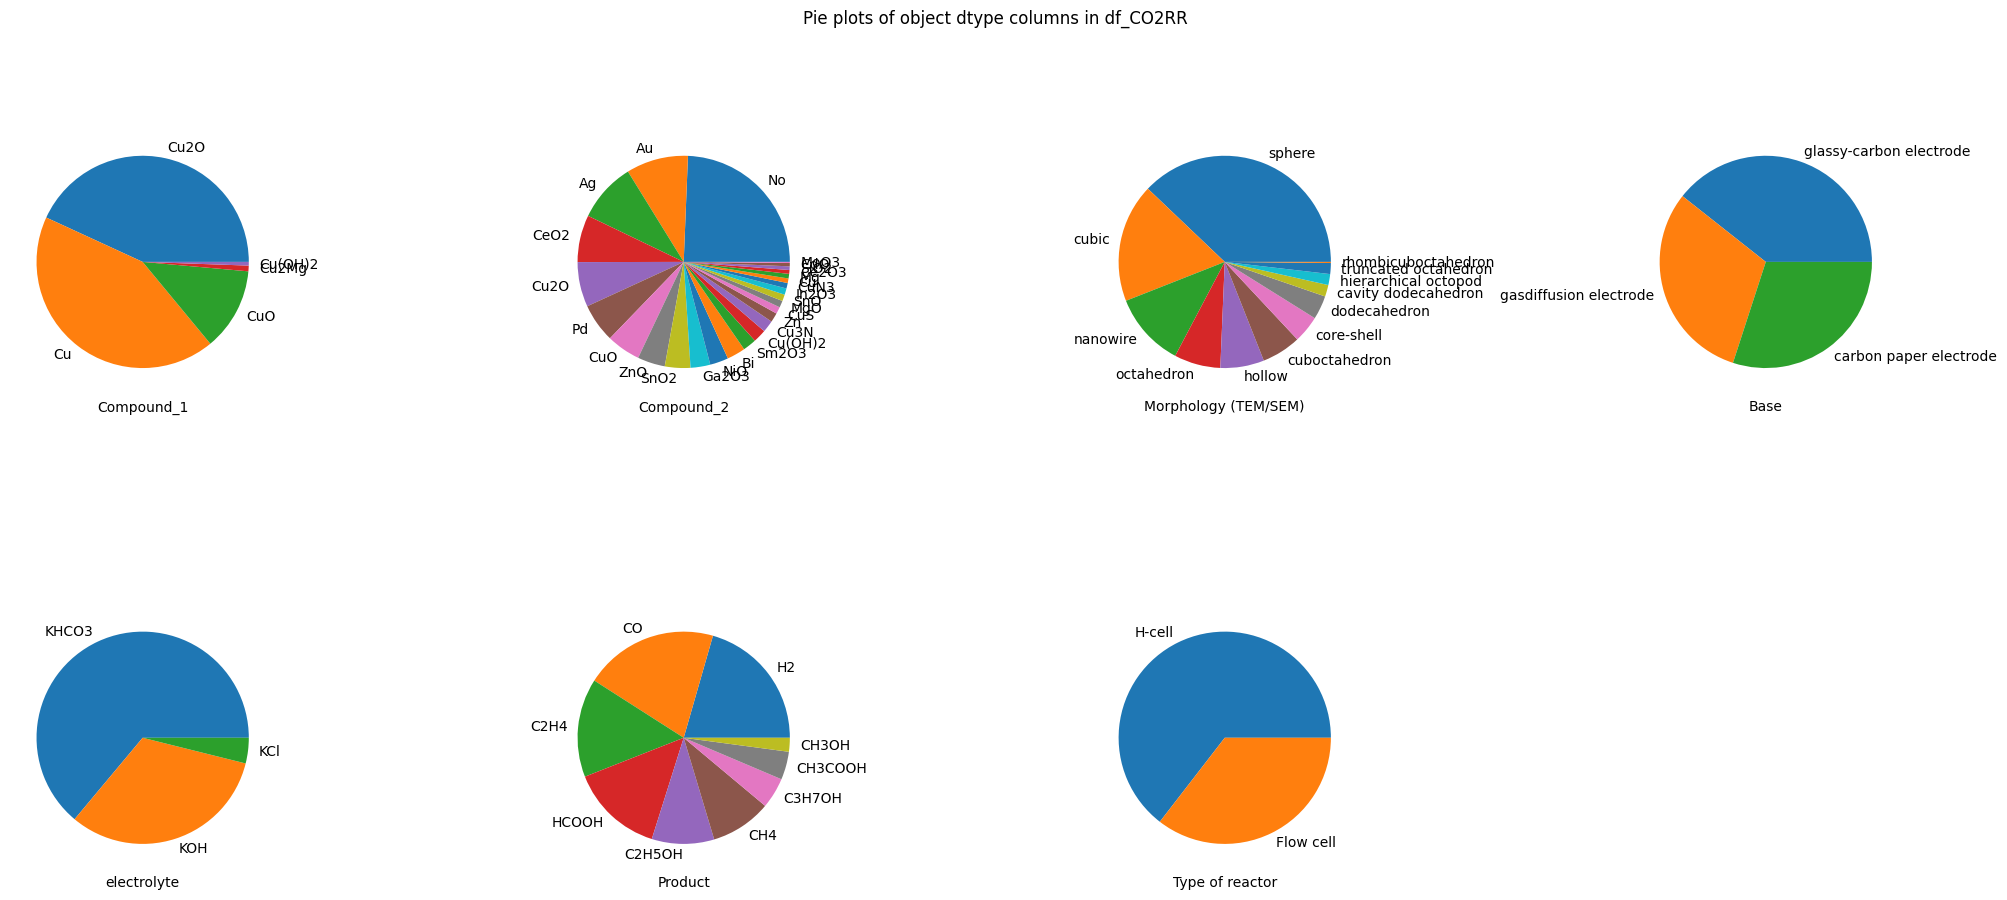

In [87]:
not_to_display = ["DOI", "Article name"]
obj_col_for_an = list(fe_cl.select_dtypes(include="object").columns)
obj_col_for_an = [col for col in obj_col_for_an if col not in not_to_display]

nrows = (len(obj_col_for_an) // 4) + (1 if len(obj_col_for_an) % 4 != 0 else 0)
fig, ax = plt.subplots(nrows, 4, figsize=(20, 10))
ax = ax.flatten()

for i, col in enumerate(obj_col_for_an):
    ax[i].pie(fe_cl[col].value_counts(), labels=fe_cl[col].value_counts().index.to_list())
    ax[i].set_xlabel(col)

# Hide any unused subplots
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

fig.suptitle("Pie plots of object dtype columns in df_CO2RR")
plt.tight_layout()
plt.show()

# Save to one .csv

In [88]:
to_concat = [fe_cl, fe_mpapi, fe_product_rdkit, fe_electr_coded, fe_encoded_reactor, fe_encoded_base]

for df in to_concat:
    print(len(df))

3600
3600
3600
3600
3600
3600


In [89]:
fe_cl.columns

Index(['DOI', 'Article name', 'Compound_1', 'Compound_2',
       'Cat./Support ratio, % (at)', 'Morphology (TEM/SEM)', 'Pore size, nm',
       'width min (nm)', 'width aver (nm)', 'width max (nm)',
       'length min (nm)', 'length aver (nm)', 'length max (nm)', 'Cu, % (at.)',
       'Cu+, % (at.)', 'Cu(2+), % (at.)', 'Base', 'electrolyte', 'conc, M',
       'pH', 'RHE vs V', 'Product', 'FE, %', 'Time, h', 'Type of reactor',
       'Loading, μg/cm2', 'Add_carbon, %', 'Surface area of electrode, cm2',
       'Flow rate CO2, ml/min', 'Av_volume, mkm^3', 'Ratio_sphere_volume',
       'Min_volume, mkm^3', 'Max_volume, mkm^3'],
      dtype='object')

In [90]:
fe_with_all = pd.concat(to_concat, axis=1, join="inner")

In [91]:
fe_with_all.columns

Index(['DOI', 'Article name', 'Compound_1', 'Compound_2',
       'Cat./Support ratio, % (at)', 'Morphology (TEM/SEM)', 'Pore size, nm',
       'width min (nm)', 'width aver (nm)', 'width max (nm)',
       'length min (nm)', 'length aver (nm)', 'length max (nm)', 'Cu, % (at.)',
       'Cu+, % (at.)', 'Cu(2+), % (at.)', 'Base', 'electrolyte', 'conc, M',
       'pH', 'RHE vs V', 'Product', 'FE, %', 'Time, h', 'Type of reactor',
       'Loading, μg/cm2', 'Add_carbon, %', 'Surface area of electrode, cm2',
       'Flow rate CO2, ml/min', 'Av_volume, mkm^3', 'Ratio_sphere_volume',
       'Min_volume, mkm^3', 'Max_volume, mkm^3', '1_efermi',
       '1_density_atomic', '1_total_magnetization_normalized_formula_units',
       '1_energy_above_hull', '1_energy_per_atom', '1_volume', '1_band_gap',
       '2_efermi', '2_density_atomic',
       '2_total_magnetization_normalized_formula_units', '2_energy_above_hull',
       '2_energy_per_atom', '2_volume', '2_band_gap', 'Product_exactmw',
       'Prod

In [92]:
fe_with_all.to_csv('Datasets\\prepr.csv', index=0)

In [93]:
catalysts = len(fe_with_all[["DOI", "Article name"]].drop_duplicates())
articles = len(fe_with_all[["DOI"]].drop_duplicates())
print(f"Unique articles: {articles}\nUnique catalysts: {catalysts}")

Unique articles: 53
Unique catalysts: 142


In [94]:
fe_with_all.columns

Index(['DOI', 'Article name', 'Compound_1', 'Compound_2',
       'Cat./Support ratio, % (at)', 'Morphology (TEM/SEM)', 'Pore size, nm',
       'width min (nm)', 'width aver (nm)', 'width max (nm)',
       'length min (nm)', 'length aver (nm)', 'length max (nm)', 'Cu, % (at.)',
       'Cu+, % (at.)', 'Cu(2+), % (at.)', 'Base', 'electrolyte', 'conc, M',
       'pH', 'RHE vs V', 'Product', 'FE, %', 'Time, h', 'Type of reactor',
       'Loading, μg/cm2', 'Add_carbon, %', 'Surface area of electrode, cm2',
       'Flow rate CO2, ml/min', 'Av_volume, mkm^3', 'Ratio_sphere_volume',
       'Min_volume, mkm^3', 'Max_volume, mkm^3', '1_efermi',
       '1_density_atomic', '1_total_magnetization_normalized_formula_units',
       '1_energy_above_hull', '1_energy_per_atom', '1_volume', '1_band_gap',
       '2_efermi', '2_density_atomic',
       '2_total_magnetization_normalized_formula_units', '2_energy_above_hull',
       '2_energy_per_atom', '2_volume', '2_band_gap', 'Product_exactmw',
       'Prod

In [353]:
exper_cond = ["DOI", "Article name", 'electrolyte', 'conc, M', 'Type of reactor']
un_exper_cond = len(fe_with_all[exper_cond].drop_duplicates())
print(un_exper_cond)

161
